<a href="https://colab.research.google.com/github/KashyapCKotak/AI-ML-experiments/blob/master/StockTF1_4Sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import numpy as np
import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        print("data shape:",dataframe.shape)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [2]:
filename="sinewave.csv"
columns=["sinewave"]
sequence_length=3
train_test_split=0.8
data = DataLoader(filename,train_test_split,columns)


x, y = data.get_train_data(
	seq_len = sequence_length,
	normalise = False
)


data shape: (5001, 1)


In [3]:
data_gen = data.generate_train_batch(
		seq_len = 3,
		batch_size = 10,
		normalise = False
	)
print(x.shape)
print(y.shape)
print(next(data_gen)[0].shape)
print(next(data_gen)[1].shape)

(3997, 2, 1)
(3997, 1)
(10, 2, 1)
(10, 1)


In [0]:
import datetime as dt

class Timer():

	def __init__(self):
		self.start_dt = None

	def start(self):
		self.start_dt = dt.datetime.now()

	def stop(self):
		end_dt = dt.datetime.now()
		print('Time taken: %s' % (end_dt - self.start_dt))

In [0]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

class Model():
	"""A class for an building and inferencing an lstm model"""

	def __init__(self):
		self.model = Sequential()

	def load_model(self, filepath):
		print('[Model] Loading model from file %s' % filepath)
		self.model = load_model(filepath)

	def build_model(self, configs):
		timer = Timer()
		timer.start()

		for layer in configs['model']['layers']:
			neurons = layer['neurons'] if 'neurons' in layer else None
			dropout_rate = layer['rate'] if 'rate' in layer else None
			activation = layer['activation'] if 'activation' in layer else None
			return_seq = layer['return_seq'] if 'return_seq' in layer else None
			input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
			input_dim = layer['input_dim'] if 'input_dim' in layer else None

			if layer['type'] == 'dense':
				self.model.add(Dense(neurons, activation=activation))
			if layer['type'] == 'lstm':
				self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
			if layer['type'] == 'dropout':
				self.model.add(Dropout(dropout_rate))

		self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'],metrics=['mean_squared_error'])

		print('[Model] Model Compiled')
		timer.stop()

	def train(self, x, y, epochs, batch_size, save_dir=""):
		timer = Timer()
		timer.start()
		print('X shape:', (x.shape))
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			EarlyStopping(monitor='val_loss', patience=2),
			ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
		]
		modelhistory=self.model.fit(
			x,
			y,
			epochs=epochs,
			batch_size=batch_size,
			callbacks=callbacks
		)
		self.model.save(save_fname)
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()
		return modelhistory

	def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
		timer = Timer()
		timer.start()
		print('X shape:', (x.shape))
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
		self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1
		)
		
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
		print('[Model] Predicting Point-by-Point...')
		predicted = self.model.predict(data)
		predicted = np.reshape(predicted, (predicted.size,))
		return predicted

	def predict_sequences_multiple(self, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

	def predict_sequence_full(self, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		print('[Model] Predicting Sequences Full...')
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted

In [0]:
configJson={
	"data": {
		"filename": "sinewave.csv",
		"columns": [
			"sinewave"
		],
		"sequence_length": 50,
		"train_test_split": 0.8,
		"normalise": False
	},
	"training": {
		"epochs": 4,
		"batch_size": 32
	},
	"model": {
		"loss": "mse",
		"optimizer": "adam",
		"layers": [
			{
				"type": "lstm",
				"neurons": 50,
				"input_timesteps": 49,
				"input_dim": 1,
				"return_seq": True
			},
			{
				"type": "dropout",
				"rate": 0.05
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": False
			},
			{
				"type": "dropout",
				"rate": 0.05
			},
			{
				"type": "dense",
				"neurons": 1,
				"activation": "linear"
			}
		]
	}
}

In [34]:
configs = configJson

data = DataLoader(
	os.path.join(configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)

model = Model()
model.build_model(configs)
x, y = data.get_train_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)

modelhistory=model.train(
	x,
	y,
	epochs = configs['training']['epochs'],
	batch_size = configs['training']['batch_size']
)

x_test, y_test = data.get_test_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)

data shape: (5001, 1)
[Model] Model Compiled
Time taken: 0:00:00.529072
X shape: (3950, 49, 1)
[Model] Training Started
[Model] 7 epochs, 64 batch size
Epoch 1/7
3950/3950 [==============================] - 14s 4ms/step - loss: 0.0616 - mean_squared_error: 0.0616
Epoch 2/7
  64/3950 [..............................] - ETA: 12s - loss: 9.8032e-04 - mean_squared_error: 9.8032e-04

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3950/3950 [==============================] - 12s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/7
3950/3950 [==============================] - 12s 3ms/step - loss: 9.9664e-04 - mean_squared_error: 9.9664e-04
Epoch 4/7
3950/3950 [==============================] - 12s 3ms/step - loss: 9.1152e-04 - mean_squared_error: 9.1152e-04
Epoch 5/7
3950/3950 [==============================] - 12s 3ms/step - loss: 8.1840e-04 - mean_squared_error: 8.1840e-04
Epoch 6/7
3950/3950 [==============================] - 12s 3ms/step - loss: 7.4672e-04 - mean_squared_error: 7.4672e-04
Epoch 7/7
3950/3950 [==============================] - 12s 3ms/step - loss: 8.2588e-04 - mean_squared_error: 8.2588e-04
[Model] Training Completed. Model saved as 14072019-070941-e7.h5
Time taken: 0:01:28.743008


dict_keys(['loss', 'mean_squared_error'])


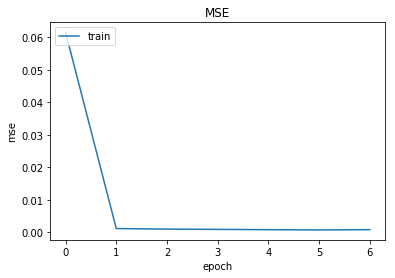

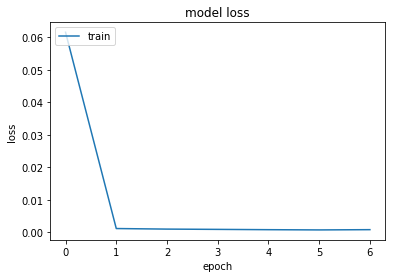

In [35]:
import matplotlib.pyplot as plt
# Visualize training history
print(modelhistory.history.keys())
# summarize history for accuracy
plt.plot(modelhistory.history['mean_squared_error'])
plt.title('MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(modelhistory.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
predictions_multiseq = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
predictions_pointbypoint = model.predict_point_by_point(x_test)        

In [0]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

    
plot_results_multiple(predictions_multiseq, y_test, configs['data']['sequence_length'])
plot_results(predictions_fullseq, y_test)
plot_results(predictions_pointbypoint, y_test)


##################################
##################################

------------------------------------------- **NOW the same for STOCKS** -------------------------------------------

##################################
##################################




In [0]:
{
	"data": {
		"filename": "sp500.csv",
		"columns": [
			"Close"
		],
		"sequence_length": 50,
		"train_test_split": 0.85,
		"normalise": True
	},
	"training": {
		"epochs": 1,
		"batch_size": 32
	},
	"model": {
		"loss": "mse",
		"optimizer": "adam",
		"layers": [
			{
				"type": "lstm",
				"neurons": 100,
				"input_timesteps": 49,
				"input_dim": 1,
				"return_seq": True
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": True
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": False
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "dense",
				"neurons": 1,
				"activation": "linear"
			}
		]
	}
}

In [0]:
configs = json.load(open('config.json', 'r'))

data = DataLoader(
	os.path.join('data', configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)

model = Model()
model.build_model(configs)

# out-of memory generative training
steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
model.train_generator(
	data_gen = data.generate_train_batch(
		seq_len = configs['data']['sequence_length'],
		batch_size = configs['training']['batch_size'],
		normalise = configs['data']['normalise']
	),
	epochs = configs['training']['epochs'],
	batch_size = configs['training']['batch_size'],
	steps_per_epoch = steps_per_epoch
)

x_test, y_test = data.get_test_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)

predictions_multiseq = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
predictions_pointbypoint = model.predict_point_by_point(x_test)        

plot_results_multiple(predictions_multiseq, y_test, configs['data']['sequence_length'])
plot_results(predictions_fullseq, y_test)
plot_results(predictions_pointbypoint, y_test)